In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from analysis._utils import *
import yaml

In [74]:
def plot_loss_vs_parameter(config_dir, vary_param, contrast_param):
    """
    Plots the minimum validation loss against a varied parameter (vary_param)
    at different levels of another control parameter (contrast_param). The minimum
    validation loss is the dependent variable. Every parameter decomposes into
    a 2-level hierarchy. For example, the parameter "model.num_layers" is
    decomposed into "model" and "num_layers". The first level is the name of the
    config file and the second level is the name of the parameter. The config
    file is the file that contains the parameter. For example, the parameter
    "model.num_layers" is in the config file "model.yaml".
    Args:
        config_dir: the directory containing the config files.
        vary_param: the independent variable.
        contrast_param: the control variable.
    """
    # go through all the config files and get the parameters and the loss
    configs = {}  # dict mapping config file path to (loss, config)
    for file_path in find_config_files(config_dir):
        with open(file_path, "r") as f:
            data = yaml.safe_load(f)
            parent_dir = os.path.dirname(file_path)
            if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
                loss_df = pd.read_csv(
                    os.path.join(parent_dir, "loss_curves.csv"), index_col=0
                )
                # we use the minimum validation loss as our metric
                loss = loss_df["centered_test_losses"][
                    loss_df["centered_test_losses"].idxmin()
                ]
                configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))
    # the parameter to vary (the independent variable)
    vary_param = vary_param.split(".")
    # the parameter to control (the control variable)
    contrast_param = contrast_param.split(".")
    # dict mapping levels of the contrast param to a dict mapping values of the varied param to the minimum test loss
    lvl_to_val_to_loss = {}
    # get the minimum loss for each value of the varied parameter
    for cfg_path, loss_cfg_tuple in configs.items():
        lvl = loss_cfg_tuple[1][contrast_param[0]][contrast_param[1]]
        num_worms = loss_cfg_tuple[1]["globals"]["num_unique_worms"]
        num_neurons = loss_cfg_tuple[1]["globals"]["num_covered_neurons"]
        val = loss_cfg_tuple[1][vary_param[0]][vary_param[1]]
        loss = loss_cfg_tuple[0]
        # accumulate the losses for each control x value param pair
        if lvl in lvl_to_val_to_loss:
            if val in lvl_to_val_to_loss[lvl]:
                lvl_to_val_to_loss[lvl][val].append(loss)
            else:
                lvl_to_val_to_loss[lvl].update({val: [loss]})
        else:
            lvl_to_val_to_loss[lvl] = {val: [loss]}
    # plot the loss vs the varied parameter coloring points by the control parameter
    for lvl, val_to_loss in lvl_to_val_to_loss.items():
        values, losses = zip(*sorted(val_to_loss.items()))
        print("\tvalues: {}\n\tlosses: {}".format(values, losses), end="\n\n")
        # TODO: allow for repetitions of the contrast param
        plt.plot(
            np.log10(values),
            [np.mean(l) for l in losses],
            label=lvl,
            marker="o",
        )
    plt.legend(loc="best", title="{} {}".format(*contrast_param))
    plt.xlabel("$\log_{10}$ %s %s" % (vary_param[0], vary_param[1]))
    plt.ylabel("Validation Loss")
    plt.title(
        "Scaling plot: loss vs {} {} \n Validation loss after 1 training epoch on different {}s".format(
            *vary_param, contrast_param[0]
        )
    )
    plt.savefig("scaling_plot_val_loss_vs_{}_{}.png".format(*vary_param))

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
	values: (12, 24, 36, 48, 60)
	losses: ([0.31879312, 0.31879312, 0.31879312], [0.31781885], [0.31765175], [0.31819117], [0.31825432])

	values: (12, 24, 36, 48, 60)
	losses: ([0.322086, 0.322086, 0.322086], [0.31911266], [0.3191855], [0.3189199], [0.31841123, 0.31841123])

	values: (6, 18, 30, 36, 48, 60)
	losses: ([0.33125812, 0.33125812], [0.32489544], [0.3235365], [0.3238772], [0.32260743], [0.32142764])

	values: (19, 38)
	losses: ([0.33843938, 0.33843938, 0.33843938, 0.33843938], [0.3314564, 0.3314564])

	values: (44,)
	losses: ([0.25379387, 0.25379387, 0.25379387, 0.25379387],)



OSError: [Errno 28] No space left on device: 'scaling_plot_val_loss_vs_train_train_size.png'

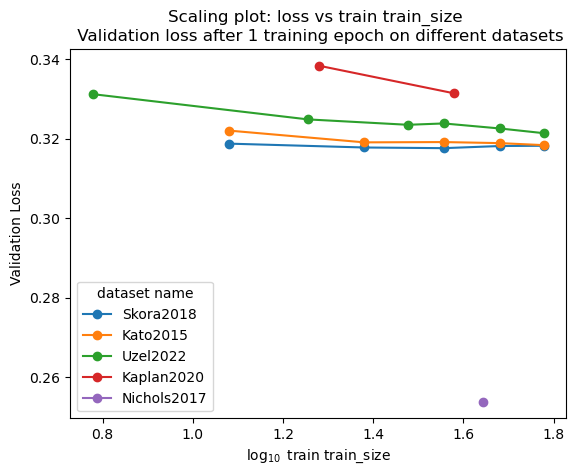

In [76]:
plot_loss_vs_parameter(
    "../logs/hydra/2023_04_21_00_27_30", "train.train_size", "dataset.name"
)